# AutoRegression MovingAverage Model on Stock Prices

### Imports

In [2]:
import pandas as pd
import numpy as np
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta 
from tqdm import tqdm_notebook as tqdm
plt.style.use('bmh')

In [3]:
df = pd.read_csv('SPY.csv')

df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-05-04,211.229996,212.020004,211.100006,211.320007,191.227142,70927200
1,2015-05-05,211.029999,211.460007,208.729996,208.899994,189.037262,113326200
2,2015-05-06,209.559998,209.929993,206.759995,208.039993,188.259018,135060200
3,2015-05-07,207.919998,209.380005,207.520004,208.869995,189.010117,88244900
4,2015-05-08,210.880005,211.860001,210.779999,211.619995,191.498642,155877300
5,2015-05-11,211.570007,211.889999,210.520004,210.610001,190.584671,75708100
6,2015-05-12,209.610001,210.630005,208.619995,209.979996,190.014572,119727600
7,2015-05-13,210.470001,211.220001,209.740005,210.020004,190.050766,94667900
8,2015-05-14,211.240005,212.320007,210.910004,212.210007,192.032532,95934000
9,2015-05-15,212.440002,212.610001,211.860001,212.440002,192.240662,76510100


## Preprocessing Data

### Datetime Conversion

In [4]:
# Datetime conversion
df['Date'] = pd.to_datetime(df.Date)

# Setting the index
df.set_index('Date', inplace=True)

# Dropping any NaNs
df.dropna(inplace=True)

In [5]:
df[['Close']]

,Close
Date,
2015-05-04,211.320007
2015-05-05,208.899994
2015-05-06,208.039993
2015-05-07,208.869995
2015-05-08,211.619995
2015-05-11,210.610001
2015-05-12,209.979996
2015-05-13,210.020004
2015-05-14,212.210007


### Scaling

In [6]:
scaler = MinMaxScaler()

# Scaling and Dropping other columns besides Close
df = pd.DataFrame(scaler.fit_transform(df[['Close']]),
                  index=df.index,
                  columns=df[['Close']].columns)

## Visualizing the Data

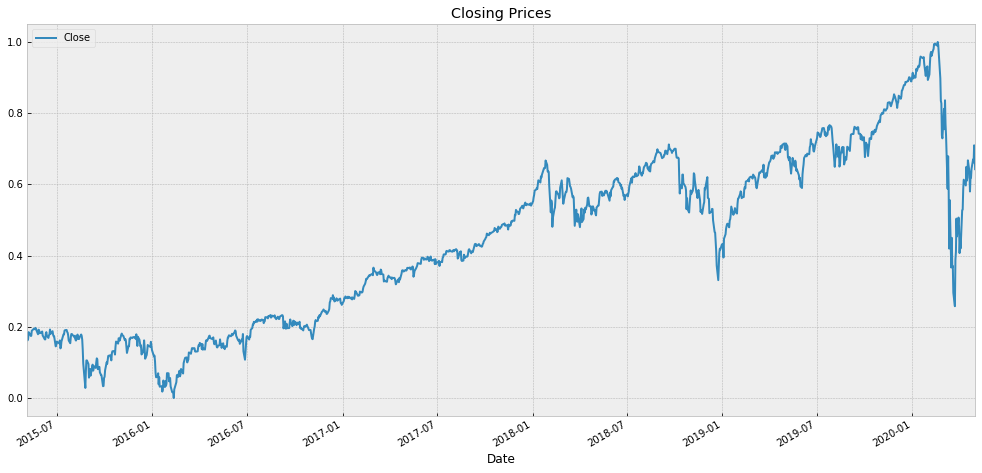

In [7]:
df.plot(figsize=(17,8), title='Closing Prices');

## Detrending

### Differencing the Data

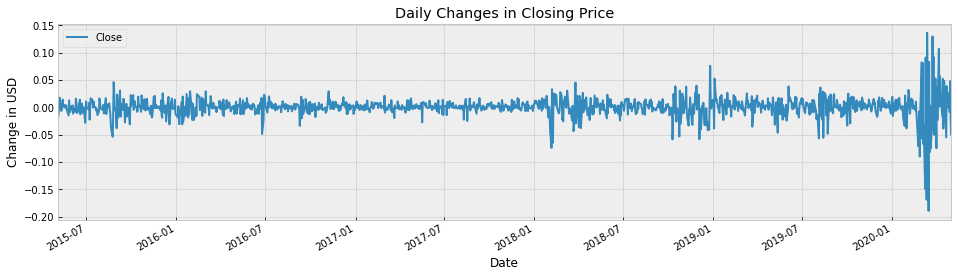

Testing for Stationarity
	P-value: 1.7720335724722586e-18


In [8]:
# Differencing
df_diff = df.diff(1).dropna()

# Plotting
df_diff.plot(figsize=(16,4), title="Daily Changes in Closing Price")
plt.ylabel("Change in USD")
plt.show()

# Stationarity Testing
results = adfuller(df_diff.iloc[:,0].values)
print(f"Testing for Stationarity\n\tP-value: {results[1]}")

### ACF and PACF

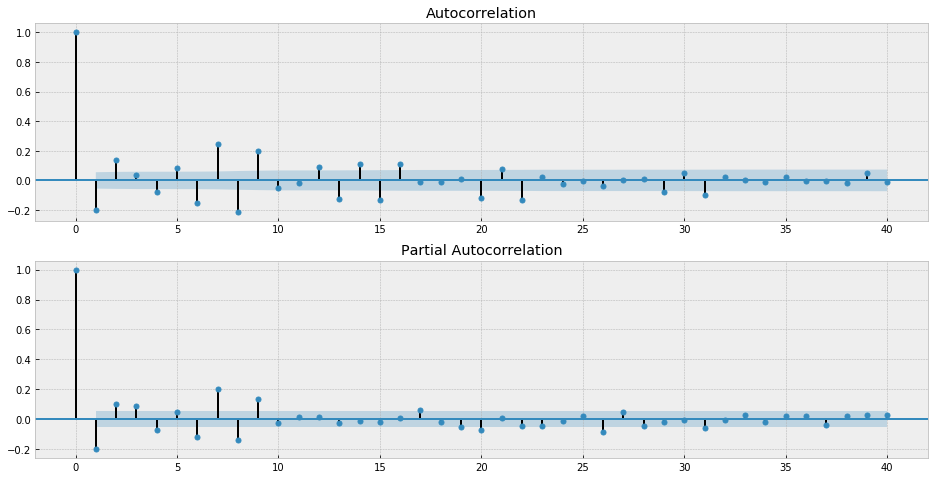

In [9]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))
plot_acf(df_diff, ax=ax1, lags=40)
plot_pacf(df_diff, ax=ax2, lags=40)
plt.show()

## Parameter Search
Using a function to find the best parameters for the ARMA model

In [10]:
# Assigning variables to the p and q values
p = q = range(0,5)

# Finding all possible combinations of p and q
pq = list(itertools.product(p, q))


def param_search(model, data, pq):
    """
    Loops through each iteration of the model and returns the best performing parameter
    """
    
    # Empty dictionary containing the combination and AIC score
    lst = []
    
    # Loop to find the best combination
    for comb in tqdm(pq):
        try:
            # Instantiating the model
            mod = model(data,
                        order=comb)
            
            # Fitting the model
            output = mod.fit()
            
            # Appending to the list
            lst.append([comb, output.aic])
        
        except:
            continue
            
    # Sorting the list
    lst = sorted(lst, key=lambda i: i[1])
    
    # Returning the combination with the lowest score
    return lst[0]

## Modeling

#### Train, Test, Splitting

In [11]:
# Splitting 80/20
index = round(len(df)*.80)

train = df.iloc[:index]
test = df.iloc[index:]

In [12]:
best_parameter = param_search(ARMA, train, pq)

print("Best p, q combination:", best_parameter[0])

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh


Best p, q combination: (4, 3)


### Fitting the Model

In [13]:
model = ARMA(train,
             order=best_parameter[0])


output = model.fit()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


### Summary and Diagnostics

In [14]:
print(output.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 1007
Model:                     ARMA(4, 3)   Log Likelihood                2943.326
Method:                       css-mle   S.D. of innovations              0.013
Date:                Thu, 11 Jun 2020   AIC                          -5868.652
Time:                        12:13:50   BIC                          -5824.419
Sample:                             0   HQIC                         -5851.846
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4032      0.163      2.479      0.013       0.084       0.722
ar.L1.Close     0.5634      0.063      8.909      0.000       0.439       0.687
ar.L2.Close    -0.1376      0.091     -1.515    

### Forecasting

In [15]:
# Getting Forecast and Confidence Intervals
forecast = output.forecast(len(test))
fc       = forecast[0]
conf     = forecast[-1]

# Putting the Data into a Pandas Series
fc_series = pd.Series(fc, index=test.index)
up_conf   = pd.Series(conf[:, 0], index=test.index)
low_conf  = pd.Series(conf[:, 1], index=test.index)

### Validating

In [16]:
predictions = output.predict(start=1, end=len(train))

preds = pd.Series(predictions.values, index=train.index)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


### Plotting

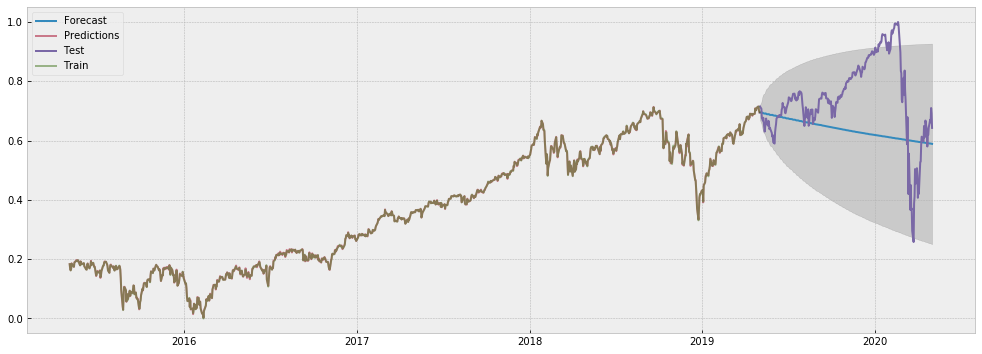

In [17]:
plt.figure(figsize=(17,6))

# Forecast plot
plt.plot(fc_series, label='Forecast')
# Confidence Interval shaded
plt.fill_between(low_conf.index, low_conf, up_conf, color='k', alpha=.15)
# Predictions against Training data
plt.plot(preds, label='Predictions', alpha=.5)

# Train and Test Plot
plt.plot(test, label='Test')
plt.plot(train, label='Train', alpha=.5)

# Plotting
plt.legend()
plt.show()

## Future Modeling

### Finding the Best Parameters for the Entire Dataset

In [18]:
# Searching for the optimum parameters
best_param = param_search(ARMA, df, pq)

print("Best p, q combination for the entire dataset:", best_parameter[0])

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh


Best p, q combination for the entire dataset: (4, 3)


### Fitting the Model to the Entire Dataset

In [19]:
model = ARMA(df,
             order=best_param[0])


output = model.fit()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


### Summary and Diagnostics

In [20]:
print(output.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 1259
Model:                     ARMA(3, 2)   Log Likelihood                3257.112
Method:                       css-mle   S.D. of innovations              0.018
Date:                Thu, 11 Jun 2020   AIC                          -6500.224
Time:                        12:14:01   BIC                          -6464.257
Sample:                             0   HQIC                         -6486.707
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4288      0.148      2.895      0.004       0.139       0.719
ar.L1.Close    -0.7411      0.026    -28.707      0.000      -0.792      -0.691
ar.L2.Close     0.8388      0.011     77.895    

### Forecasting the Future

In [21]:
# Number of Periods to forecast
periods = 90

# Getting Forecast and Confidence Intervals
forecast = output.forecast(periods)
fc       = forecast[0].reshape(-1,1)
conf     = forecast[-1]

# Putting the Data into a Pandas Series
fc_series = pd.DataFrame(scaler.inverse_transform(fc), 
                         index=pd.date_range(start=df.index[-1]+timedelta(days=1), periods=periods, freq="B"))

up_conf   = pd.DataFrame(scaler.inverse_transform(conf[:, 0].reshape(-1,1)), 
                         index=pd.date_range(start=df.index[-1]+timedelta(days=1), periods=periods, freq="B"))

low_conf  = pd.DataFrame(scaler.inverse_transform(conf[:, 1].reshape(-1,1)), 
                         index=pd.date_range(start=df.index[-1]+timedelta(days=1), periods=periods, freq="B"))

# Unscaling the DF
df = pd.DataFrame(scaler.inverse_transform(df).reshape(1,-1)[0],
                  index=df.index)

### Plotting the Forecast

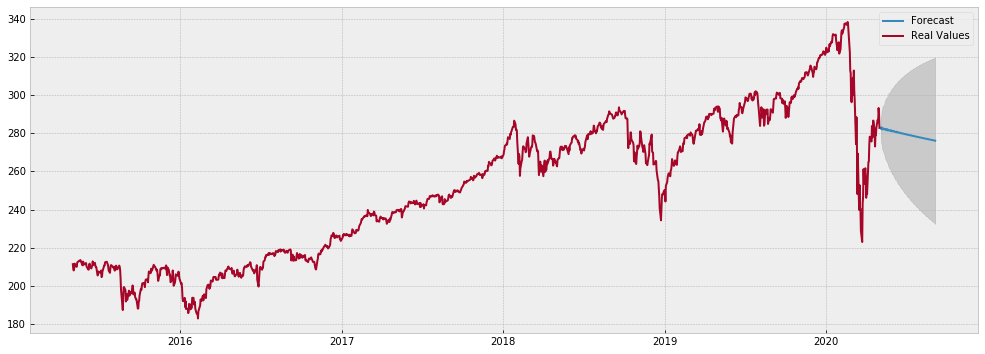

In [22]:
plt.figure(figsize=(17,6))

# Forecast plot
plt.plot(fc_series, label='Forecast')
# Confidence Interval shaded
plt.fill_between(low_conf.index, low_conf[0], up_conf[0], color='k', alpha=.15)

# Plotting the Real Values
plt.plot(df, label="Real Values")

# Plotting
plt.legend()
plt.show()

### Zooming In on the Forecast

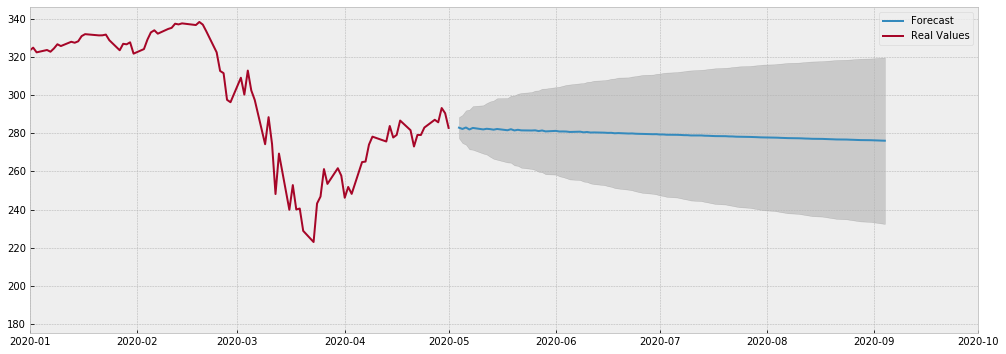

In [23]:
plt.figure(figsize=(17,6))

# Forecast plot
plt.plot(fc_series, label='Forecast')
# Confidence Interval shaded
plt.fill_between(low_conf.index, low_conf[0], up_conf[0], color='k', alpha=.15)

# Plotting the Real Values
plt.plot(df, label="Real Values")

# Zooming In
plt.xlim("2020", "2020-10")

# Plotting
plt.legend()
plt.show()

## Trading the Model
Create a simple trading algorithm based on the model's predictions.

In [29]:
df.rename(columns={0:'Close'}, inplace=True)

In [ ]:
def trading(df, starting):
    """
    A simple trading algorithm to trade the DF
    """
    
    cash = 1000
    
    

In [37]:
df['DailyReturns'] = df.pct_change()

In [38]:
df

,Close,DailyReturns
Date,,
2015-05-04,211.320007,NaN
2015-05-05,208.899994,-0.011452
2015-05-06,208.039993,-0.004117
2015-05-07,208.869995,0.003990
2015-05-08,211.619995,0.013166
2015-05-11,210.610001,-0.004773
2015-05-12,209.979996,-0.002991
2015-05-13,210.020004,0.000191
2015-05-14,212.210007,0.010428


In [39]:
cash = 1000

balance = []

for i in range(len(df.Close)):
    if i == 0:
        balance.append(df.Close[i] * (cash // df.Close[i]))
    else:
        balance.append((df.DailyReturns[i]+1) * balance[i-1])

In [43]:
df['CashBalance'] = balance

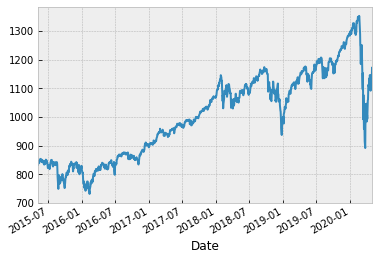

In [44]:
df.CashBalance.plot()

### Run the ARMA model for predictions over a timeframe that constantly is added to or slides

In [ ]:
# Days to predict in the future
pred_periods = 5

# List containing predicted prices
pred_prices = []

# Assigning variables to the p and q values
p = q = range(0,5)

# Finding all possible combinations of p and q
pq = list(itertools.product(p, q))

for i in range(len(df.Close)):
    
    # Skipping the first 300 prices
    if i < 300:
        pred_prices.append(None)
        
    else:
        
        # Finding the best parameters so far
        best_param = param_search(ARMA, df.Close[:i], pq)

        # Fitting the model
        model = ARMA(df.Close[:i],
                     order=best_param[0])


        output = model.fit()
        
        # Getting and appending predictions
        predictions = output.forecast(pred_periods)
        
        pred_prices.extend(predictions[0])